In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
from sklearn.preprocessing import minmax_scale, maxabs_scale
from dispatches.models.renewables_case.summarize_results import summarize_and_concat
from dispatches.models.renewables_case.result_analysis_utils import calc_npv, plot_contours
import os

In [2]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
batch_1_option_summary = "sim_option_summary.csv"
batch_1_summary = "sim_result_summary.csv"
batch_1_dir_generator = lambda sim_id: os.path.join(".", f"sim_{sim_id}_results")

batch_2_option_summary = "batch_2_sim_option_summary.csv"
batch_2_summary = "batch_2_sim_result_summary.csv"
batch_2_dir_generator = lambda sim_id: os.path.join(".", f"batch_2_sim_{sim_id}_results")

if os.path.exists(batch_1_option_summary) and os.path.exists(batch_1_summary):
    option_df = pd.read_csv(batch_1_option_summary)
    result_df = pd.read_csv(batch_1_summary, index_col="sim_id")
else:
    result_dir_generator = batch_1_dir_generator
    sim_id_list = list(range(400))

    option_df, result_df = summarize_and_concat(
        sim_id_list, result_dir_generator, bus_name="Carter", gen_name="309_WIND_1"
    )

    # write to csv
    option_df.to_csv(batch_1_option_summary)
    result_df.to_csv(batch_1_summary)

option_df.drop(columns=["sim_id"], inplace=True)
result_df = result_df.drop("base").reset_index()
# option_df.set_index("sim_id", inplace=True)

In [4]:
df = pd.concat([result_df, option_df], axis=1)
df

,sim_id,Dispatch,Dispatch DA,Revenue DA,Revenue RT,Total Revenue,battery_energy_capacity,battery_pmax,n_scenario,participation_mode,reserve_factor,wind_pmax
0,0,44495.168495,30752.160484,1.124899e+06,2.549069e+07,2.661559e+07,40.0,10.0,3,Bid,0.0,50.0
1,1,86558.094016,44316.739557,1.152740e+06,2.247175e+07,2.362449e+07,40.0,10.0,3,SelfSchedule,0.0,50.0
2,2,45145.724603,33993.100807,1.329293e+06,2.239236e+07,2.372165e+07,40.0,10.0,5,Bid,0.0,50.0
3,3,90267.175886,39739.848507,9.896179e+05,2.452574e+07,2.551536e+07,40.0,10.0,5,SelfSchedule,0.0,50.0
4,4,47562.546234,35509.172671,1.229186e+06,2.252576e+07,2.375495e+07,40.0,10.0,8,Bid,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,604669.485566,287470.838706,3.525453e+06,-1.438504e+08,-1.403249e+08,2000.0,500.0,5,SelfSchedule,0.0,500.0
396,396,393770.912159,257157.257946,9.055591e+06,-6.382197e+07,-5.476638e+07,2000.0,500.0,8,Bid,0.0,500.0
397,397,572327.634862,220372.640291,2.948836e+06,-1.893716e+07,-1.598832e+07,2000.0,500.0,8,SelfSchedule,0.0,500.0
398,398,417683.157333,279514.825610,9.797191e+06,-4.176011e+07,-3.196291e+07,2000.0,500.0,10,Bid,0.0,500.0


In [5]:
df["pmax_ratio"] = df["battery_pmax"] / df["wind_pmax"]

In [6]:
df["scaled_total_revenue"] = df.groupby(["n_scenario", "participation_mode"]).apply(
    lambda x: pd.DataFrame(minmax_scale(x["Total Revenue"]), x.index)
)

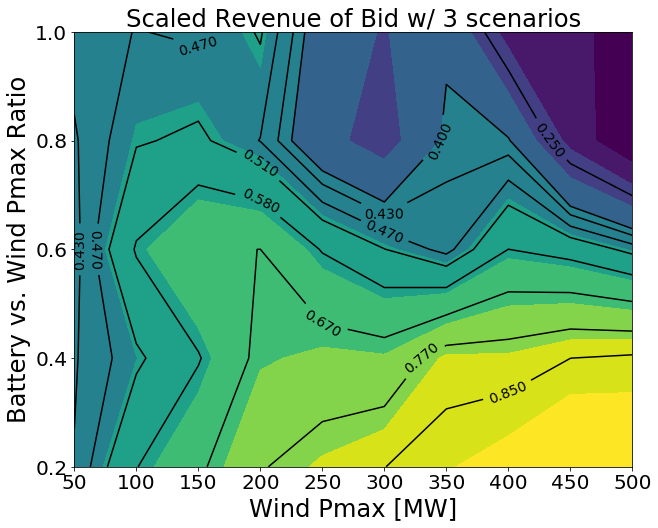

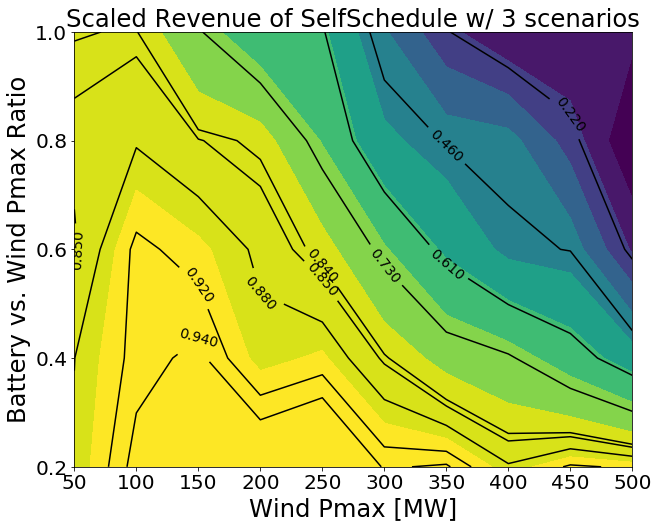

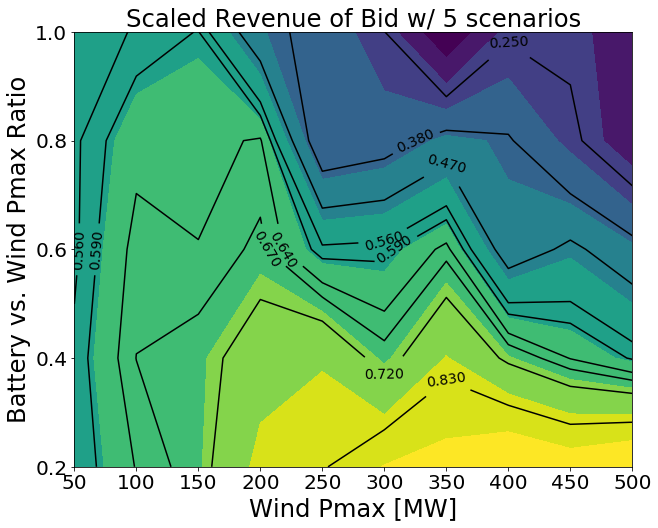

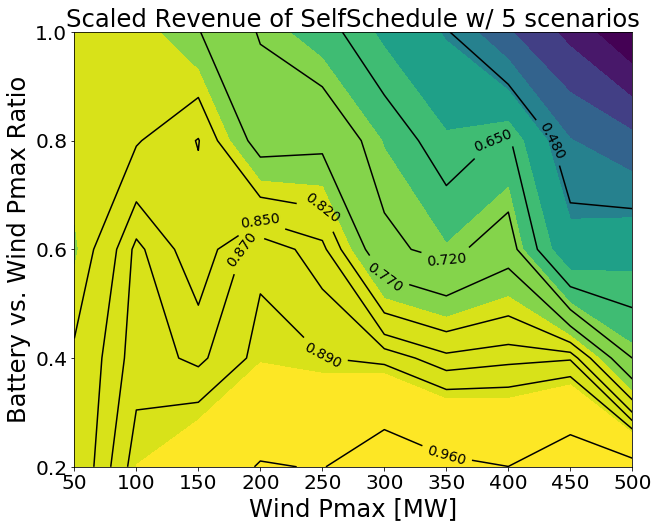

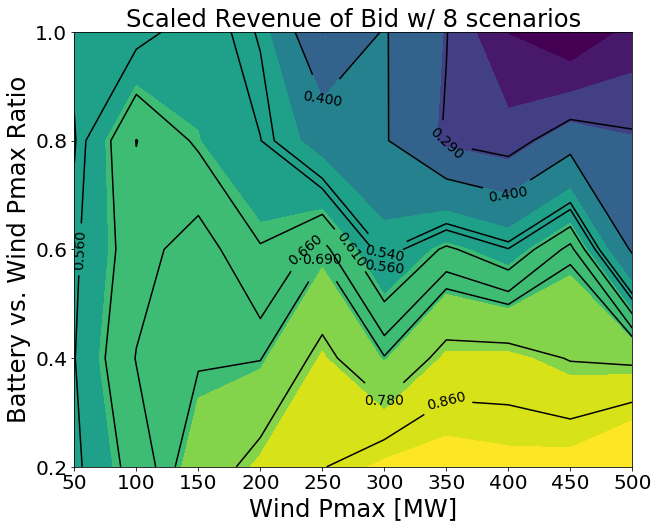

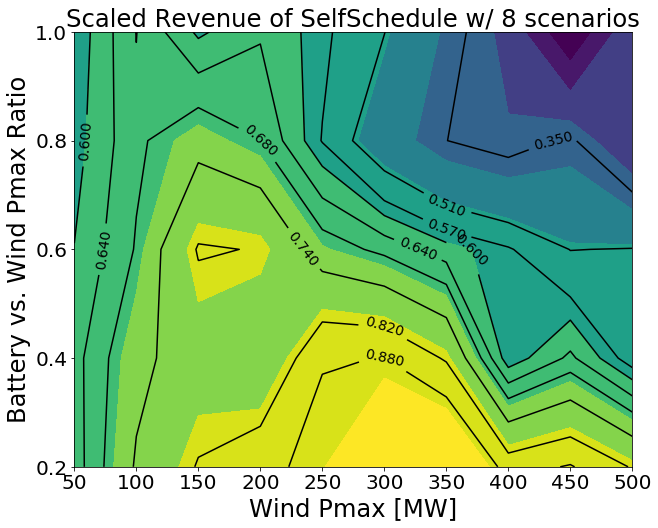

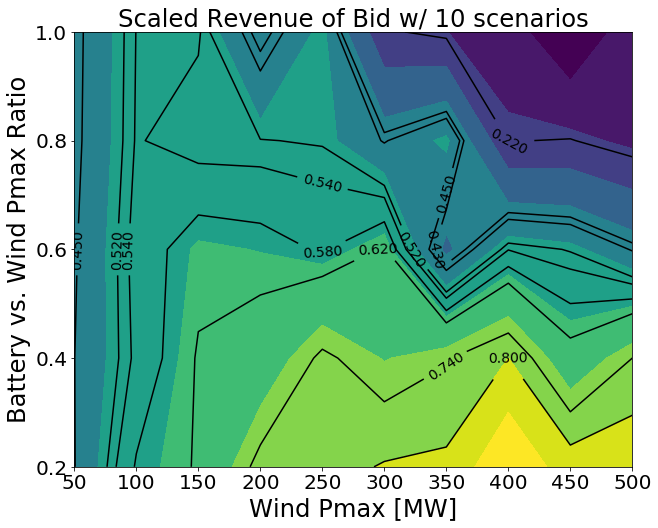

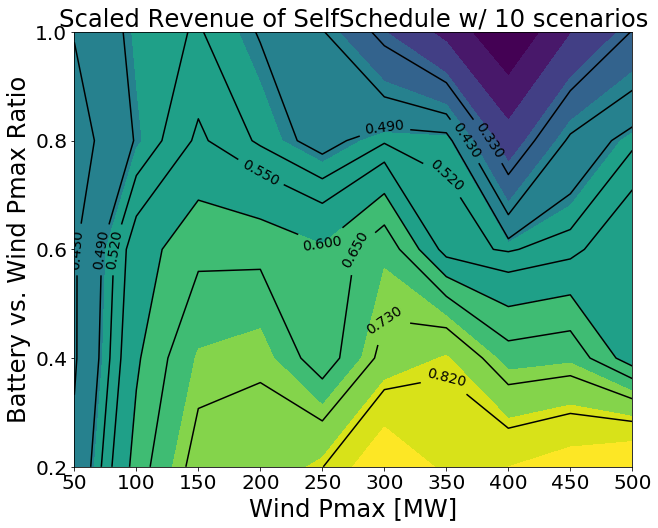

In [7]:
def plot_scaled_revenue_contour(df):
    ax = plot_contours(df, "wind_pmax", "pmax_ratio", "scaled_total_revenue", 10, "Wind Pmax [MW]", "Battery vs. Wind Pmax Ratio")
    pm = df["participation_mode"].iloc[0]
    n_scenario = df["n_scenario"].iloc[0]
    ax.set_title(f"Scaled Revenue of {pm} w/ {n_scenario} scenarios", fontsize="xx-large")
    return ax

axes = df.groupby(["n_scenario", "participation_mode"]).apply(plot_scaled_revenue_contour)

In [8]:
df["NPV"] = calc_npv(df["wind_pmax"], df["battery_pmax"], df["Total Revenue"])
df["Log NPV"] = np.log10(df["NPV"])
df["Log NPV"].fillna(0, inplace=True)


/afs/crc.nd.edu/user/x/xgao1/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
max_log_NPV = df["Log NPV"].max()
min_log_NPV = 7

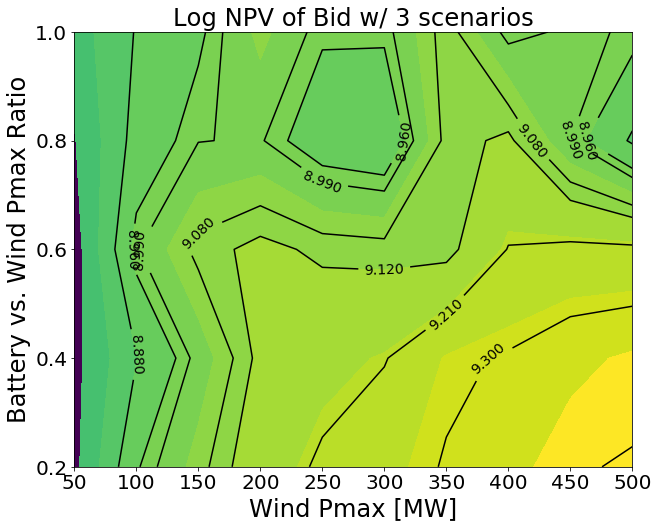

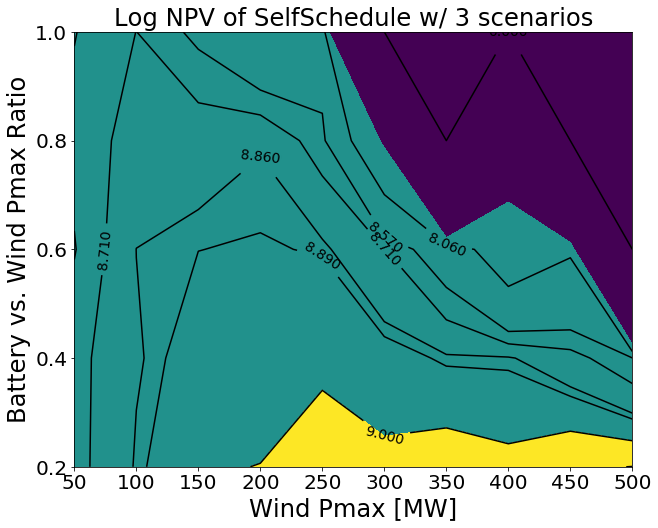

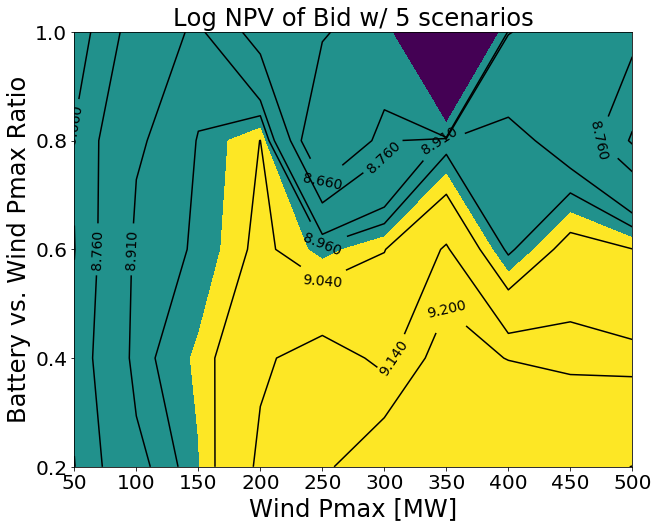

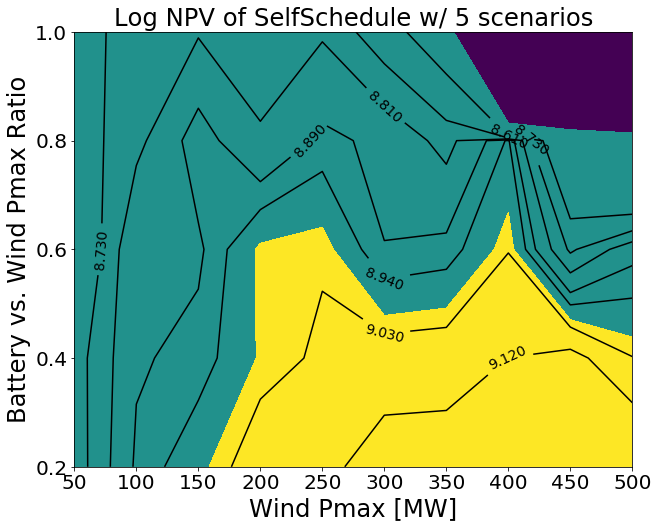

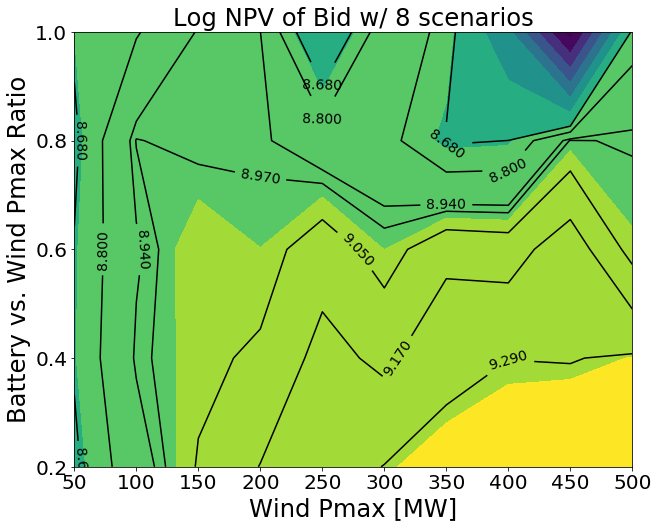

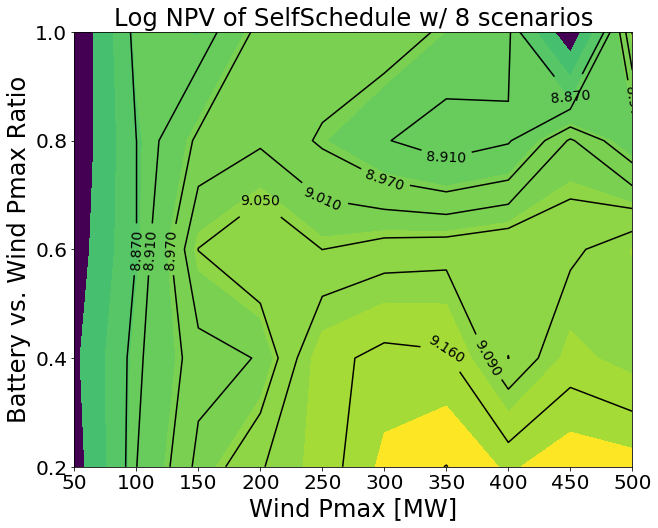

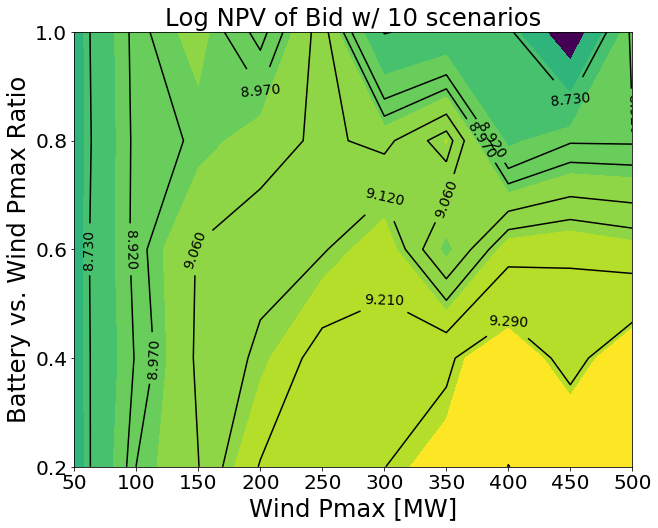

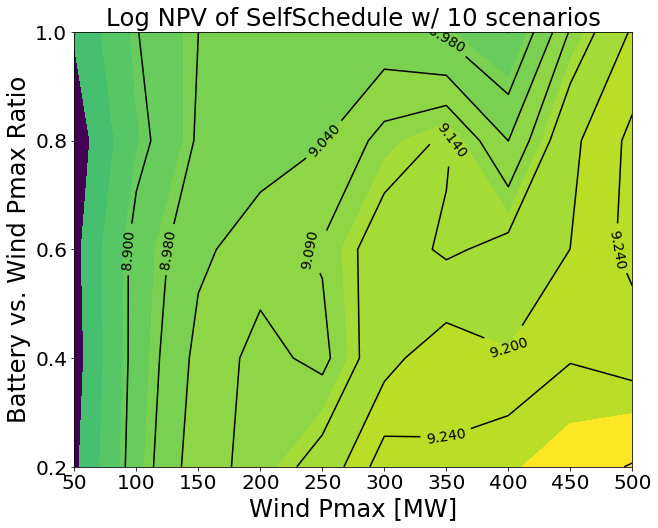

In [10]:
def plot_log_NPV_contour(df):
    ax = plot_contours(
        df, 
        "wind_pmax", 
        "pmax_ratio", 
        "Log NPV", 
        8, 
        "Wind Pmax [MW]", 
        "Battery vs. Wind Pmax Ratio",
        vmin=7,
        vmax=9.5,
    )
    pm = df["participation_mode"].iloc[0]
    n_scenario = df["n_scenario"].iloc[0]
    ax.set_title(f"Log NPV of {pm} w/ {n_scenario} scenarios", fontsize="xx-large")
    return ax

axes = df.groupby(["n_scenario", "participation_mode"]).apply(plot_log_NPV_contour)

In [11]:
dir_name = "./sensitivity_agg_results"
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

In [12]:
df.groupby("n_scenario")["Log NPV"].agg(["mean", "median", "std"]).to_csv(os.path.join(dir_name, "n_scenarios_log_npv_agg.csv"))

In [13]:
df.groupby("n_scenario")["NPV"].agg(["mean", "median", "std"]).to_csv(os.path.join(dir_name, "n_scenarios_npv_agg.csv"))

In [14]:
df.groupby("participation_mode")["Log NPV"].agg(["mean", "median", "std"]).to_csv(os.path.join(dir_name, "pm_log_npv_agg.csv"))

In [15]:
df.groupby("participation_mode")["NPV"].agg(["mean", "median", "std"]).to_csv(os.path.join(dir_name, "pm_npv_agg.csv"))

Combine the results with price taker

In [16]:
df = df.reset_index()
df = df.astype({"sim_id": "int"})
df["price_type"] = "DA+RT"
df = df[
    [
    "sim_id", 
    "Total Revenue", 
    "battery_energy_capacity", 
    "battery_pmax", 
    "n_scenario", 
    "participation_mode", 
    "wind_pmax", 
    "pmax_ratio",
    "price_type",
    ]
]

In [17]:
pt_df = pd.read_csv("price_taker_sensitivity_summary.csv")
pt_df.rename(columns={"revenue": "Total Revenue"}, inplace=True)
pt_df["n_scenario"] = 1
pt_df["participation_mode"] = "PriceTaker"
pt_df["pmax_ratio"] = pt_df["battery_pmax"] / pt_df["wind_pmax"]
pt_df.astype({"sim_id": "int"}, copy=False)
pt_df["sim_id"] += df["sim_id"].max() + 1


In [18]:
combined_df = pd.concat([df, pt_df])
combined_df

,sim_id,Total Revenue,battery_energy_capacity,battery_pmax,n_scenario,participation_mode,wind_pmax,pmax_ratio,price_type
0,0,2.661559e+07,40.0,10.0,3,Bid,50.0,0.2,DA+RT
1,1,2.362449e+07,40.0,10.0,3,SelfSchedule,50.0,0.2,DA+RT
2,2,2.372165e+07,40.0,10.0,5,Bid,50.0,0.2,DA+RT
3,3,2.551536e+07,40.0,10.0,5,SelfSchedule,50.0,0.2,DA+RT
4,4,2.375495e+07,40.0,10.0,8,Bid,50.0,0.2,DA+RT
...,...,...,...,...,...,...,...,...,...
145,545,1.764041e+09,1600.0,400.0,1,PriceTaker,500.0,0.8,RT
146,546,1.801912e+09,1600.0,400.0,1,PriceTaker,500.0,0.8,DA+RT
147,547,9.069531e+07,2000.0,500.0,1,PriceTaker,500.0,1.0,DA
148,548,2.029808e+09,2000.0,500.0,1,PriceTaker,500.0,1.0,RT


In [19]:
combined_df["NPV"] = calc_npv(
    wind_mw=combined_df["wind_pmax"], 
    batt_mw=combined_df["battery_pmax"], 
    annual_revenue=combined_df["Total Revenue"],
)

In [20]:
# combined_df["scaled_npv"] = minmax_scale(combined_df["NPV"])
combined_df["scaled_npv"] = maxabs_scale(combined_df["NPV"])

In [21]:
combined_df["scaled_npv"].min()


-0.03143046958465554